In [1]:
import os
import numpy as np

from astropy.table import Table

import matplotlib.pyplot as plt
%matplotlib inline

from astropy.coordinates import SkyCoord 
import astropy.units as u

from sklearn.neighbors import NearestNeighbors
from sklearn import svm, tree
#from IPython.display import Math

import pandas as pd
import seaborn as sns

D2R = np.pi/180.0

# temporary working space
wdir = os.path.expanduser('~') + '/tmp/LQSO/'

In [2]:
import matplotlib as mp
import matplotlib.pyplot as plt

In [3]:
# to drop warnings
import warnings
warnings.filterwarnings('ignore', category=Warning, append=True)

mp.rcParams['figure.figsize'] = (12, 8)

# Allwise (object type 3) query 

To read the Castle xmatch with DR2 from VOtable execute the cells below.


url1 = 'http://vospace.esac.esa.int/vospace/sh/d964d4b3687ede95d64c19609abb3136fbe55c0?dl=1'
t = Table.read(url1,format='votable')
nt = len(t)
print ("Total number of LQSO is {}".format(nt))

d = t.to_pandas()

d.to_csv(wdir+"allwiseDR2.csv")

In [4]:
%time d = pd.read_csv(wdir+"allwiseDR2.csv")

CPU times: user 10.3 s, sys: 870 ms, total: 11.2 s
Wall time: 11.5 s


In [5]:
d.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495739 entries, 0 to 495738
Columns: 100 entries, Unnamed: 0 to mu_error
dtypes: bool(2), float64(93), int64(1), object(4)
memory usage: 371.6+ MB


In [6]:
d[~np.isnan(d.radius_percentile_lower)][:1]

,Unnamed: 0,qso_id,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,...,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,mu,mu_error
10003,10003,1.900747e+18,1.635721e+18,b'Gaia DR2 1900747298789142656',1.900747e+18,1.051281e+09,2015.5,338.03089,0.025339,31.51361,...,1.310841,1.24319,1.370017,1.269214,1.096437,1.441991,b'http://geadata.esac.esa.int/data-server/data...,NaN,8.671884,0.060581


# Castles query

In [7]:
# read the Castle xmatch with DR2
url2 = 'http://vospace.esac.esa.int/vospace/sh/9da5bd4b841f4032ee3f94e2f357067a554434?dl=1'
t2 = Table.read(url2,format='votable')
nt = len(t2)
print ("Total number of LQSO is {}".format(nt))

Total number of LQSO is 87


In [8]:
d2 =  t2.to_pandas()

# Analysis of the significance of the proper motion in Castles data set

one neglect the contamination in AllWise data set

In [9]:
from astropy.coordinates import Angle
def wrap180(x):
    """
    wrap longitudes defined on [0 360] degrees to radian defined on [-pi pi]
    why should I use the minus to get the LMC where I want?
    """
    return -Angle(x,unit=u.deg).wrap_at(180*u.deg).rad

def sigma2(ea,ed,c) : 
    """ the largest eigen value of the covariance matrix defined by
    ea : right ascention error
    ed : declination error
    c  : correlation
    """
    res = np.power(ea,2) + np.power(ed,2) 
    res = res + np.sqrt(np.power(ea-ed,2) + np.power(2*ea*ed*c,2))
    return res/2

def setMu(d):
    """
    set mu, mu_error and mu_norm taking in account the correlation
    """
    d['mu'] = np.sqrt(np.power(d.pmra,2)+np.power(d.pmdec,2))
    d['mu_error'] = np.sqrt(sigma2(d.pmra_error,d.pmdec_error,d.pmra_pmdec_corr))
    d['mu_over_error'] = d.mu/d.mu_error

In [10]:
setMu(d)
setMu(d2)

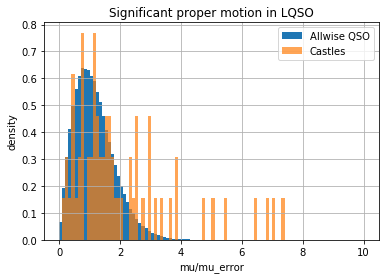

In [11]:
d[d.source_id==d.qso_id].mu_over_error.hist(bins=100,range=(0,10),normed=True,label="Allwise QSO")
d2.mu_over_error.hist(bins=100,range=(0,10),normed=True,label="Castles",alpha=0.7)
plt.title("Significant proper motion in LQSO")
plt.ylabel("density")
plt.xlabel("mu/mu_error")
plt.legend()

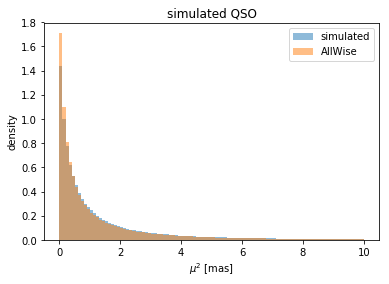

In [81]:
mu_e = d.mu_error.dropna()
mu_ra = np.random.normal(0,mu_e)
mu_dec = np.random.normal(0,mu_e)
mu2 = np.power(mu_ra,2)+np.power(mu_dec,2)
plt.hist(mu2,bins=100,range=(0,10),normed=True,alpha=0.5,label="simulated");
plt.hist(np.power(d.mu.dropna(),2),bins=100,range=(0,10),normed=True,alpha=0.5,label="AllWise");
plt.title("simulated QSO")
plt.xlabel("$\mu^2$ [mas]")
plt.ylabel("density")
plt.legend()

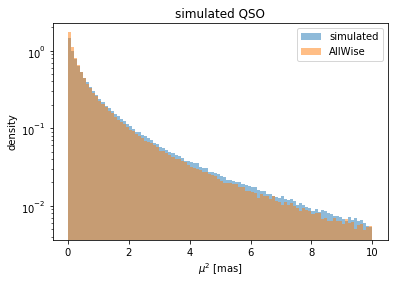

In [87]:
mu_e = d.mu_error.dropna()
mu_ra = np.random.normal(0,mu_e)
mu_dec = np.random.normal(0,mu_e)
mu2 = np.power(mu_ra,2)+np.power(mu_dec,2)
plt.hist(mu2,bins=100,range=(0,10),normed=True,alpha=0.5,label="simulated");
plt.hist(np.power(d.mu.dropna(),2),bins=100,range=(0,10),normed=True,alpha=0.5,label="AllWise");
plt.title("simulated QSO")
plt.xlabel("$\mu^2$ [mas]")
plt.ylabel("density")
plt.legend()
plt.yscale('log')

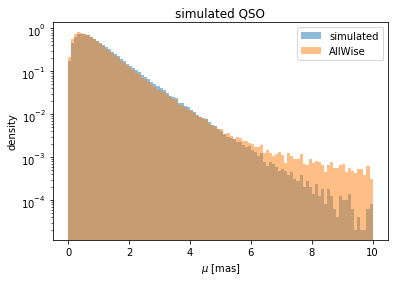

In [89]:
mu_e = d.mu_error.dropna()
mu_ra = np.random.normal(0,mu_e)
mu_dec = np.random.normal(0,mu_e)
mu2 = np.power(mu_ra,2)+np.power(mu_dec,2)
plt.hist(np.sqrt(mu2),bins=100,range=(0,10),normed=True,alpha=0.5,label="simulated");
plt.hist(d.mu.dropna(),bins=100,range=(0,10),normed=True,alpha=0.5,label="AllWise");
plt.title("simulated QSO")
plt.xlabel("$\mu$ [mas]")
plt.ylabel("density")
plt.legend()
plt.yscale('log')

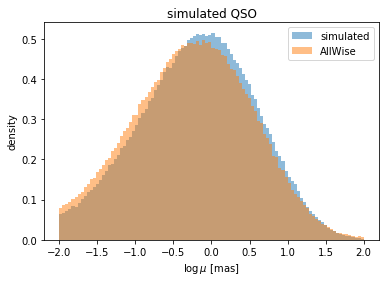

In [95]:
mu_e = d.mu_error.dropna()
mu_ra = np.random.normal(0,mu_e)
mu_dec = np.random.normal(0,mu_e)
mu2 = np.power(mu_ra,2)+np.power(mu_dec,2)
plt.hist(np.log(np.sqrt(mu2)),bins=100,range=(-2,2),normed=True,alpha=0.5,label="simulated");
plt.hist(np.log(d.mu.dropna()),bins=100,range=(-2,2),normed=True,alpha=0.5,label="AllWise");
plt.title("simulated QSO")
plt.xlabel("$\log\,\mu$ [mas]")
plt.ylabel("density")
plt.legend()

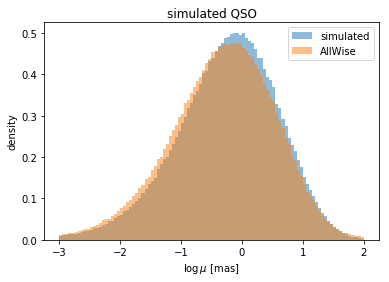

In [97]:
mu_e = d.mu_error.dropna()
mu_ra = np.random.normal(0,mu_e)
mu_dec = np.random.normal(0,mu_e)
mu2 = np.power(mu_ra,2)+np.power(mu_dec,2)
plt.hist(np.log(np.sqrt(mu2)),bins=100,range=(-3,2),normed=True,alpha=0.5,label="simulated");
plt.hist(np.log(d.mu.dropna()),bins=100,range=(-3,2),normed=True,alpha=0.5,label="AllWise");
plt.title("simulated QSO")
plt.xlabel("$\log\,\mu$ [mas]")
plt.ylabel("density")
plt.legend()

In [101]:
from scipy.stats import norm

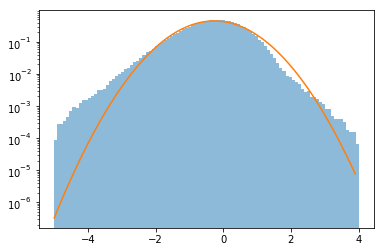

In [112]:
m = np.log(d.mu.dropna()).median()
s = np.log(d.mu.dropna()).std()
x = np.arange(-5,4,0.1)
y = norm.pdf(x,loc=m,scale=s)
plt.hist(np.log(d.mu.dropna()),bins=100,range=(-5,4),normed=True,alpha=0.5,label="AllWise");
plt.plot(x,y)
plt.yscale('log')

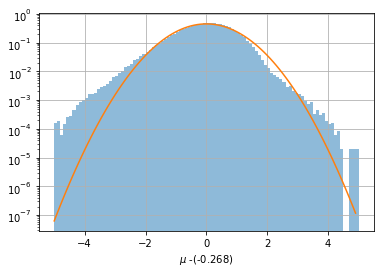

In [120]:
m = np.log(d.mu.dropna()).median()
s = np.log(d.mu.dropna()).std()
x = np.arange(-5,5,0.1)
y = norm.pdf(x,loc=0,scale=s)
plt.hist(np.log(d.mu.dropna())-m,bins=100,range=(-5,5),normed=True,alpha=0.5,label="AllWise");
plt.plot(x,y)
plt.yscale('log')
plt.grid()
plt.xlabel("$\mu$ -(%s)"%np.round(m,3));

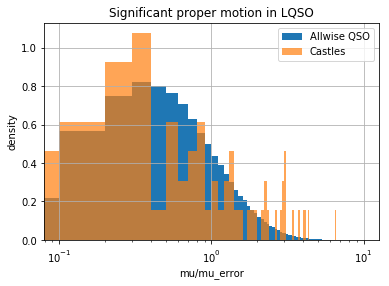

In [43]:
d[d.source_id==d.qso_id].mu.hist(bins=100,range=(0,10),normed=True,label="Allwise QSO")
d2.mu.hist(bins=100,range=(0,10),normed=True,label="Castles",alpha=0.7)
plt.title("Significant proper motion in LQSO")
plt.ylabel("density")
plt.xlabel("mu/mu_error")
plt.legend()
plt.xscale('log')

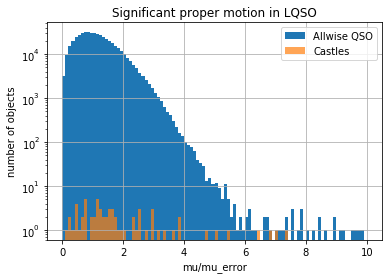

In [12]:
d[d.source_id==d.qso_id].mu_over_error.hist(bins=100,range=(0,10),label="Allwise QSO")
d2.mu_over_error.hist(bins=100,range=(0,10),label="Castles",alpha=0.7)
plt.title("Significant proper motion in LQSO")
plt.ylabel("number of objects")
plt.yscale('log')
plt.xlabel("mu/mu_error")
plt.legend()

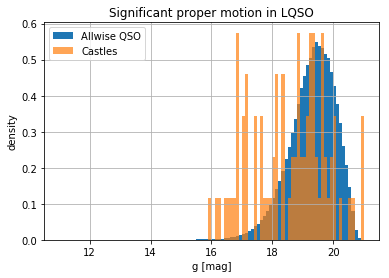

In [41]:
d[d.source_id==d.qso_id].phot_g_mean_mag.hist(bins=100,range=(11,21),normed=True,label="Allwise QSO")
d2.phot_g_mean_mag.hist(bins=100,range=(11,21),normed=True,label="Castles",alpha=0.7)
plt.title("Significant proper motion in LQSO")
plt.ylabel("density")
plt.xlabel("g [mag]")
plt.legend()

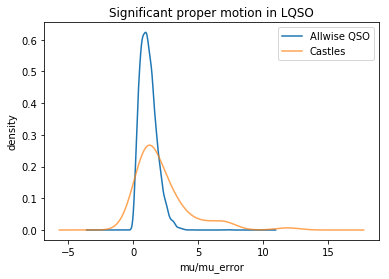

In [14]:
d[d.source_id==d.qso_id].mu_over_error.sample(frac=0.01).plot.kde(label="Allwise QSO")
d2.mu_over_error.plot.kde(label="Castles",alpha=0.7)
plt.title("Significant proper motion in LQSO")
plt.ylabel("density")
plt.xlabel("mu/mu_error")
plt.legend()

In [15]:
from sklearn.neighbors import KernelDensity
def density1d(d,X_plot,colname='mu_over_error',bandwidth=0.5):
    X_fit = d[colname].dropna().values[:, np.newaxis]
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(X_fit)
    log_dens = kde.score_samples(X_plot[:, np.newaxis])
    return np.exp(log_dens)

Text(0.5,1,'Gaussian kde with 0.5 bandwidth')

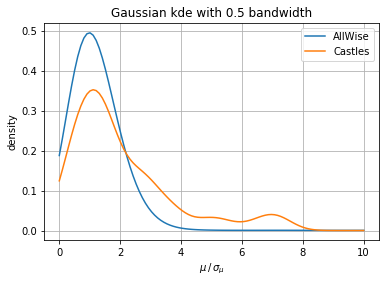

In [16]:
X = np.linspace(0, 10, 100)
plt.plot(X,density1d(d.sample(frac=0.1),X),label="AllWise")
plt.plot(X,density1d(d2,X),label="Castles")
plt.grid()
plt.ylabel("density")
plt.xlabel("$\mu \, / \, \sigma_\mu$")
plt.legend()
plt.title("Gaussian kde with 0.5 bandwidth")

Text(0.5,1,'Gaussian kde with 0.5 bandwidth')

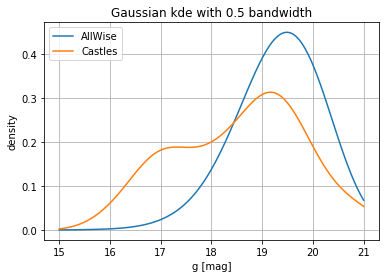

In [17]:
X = np.linspace(15, 21, 100)
plt.plot(X,density1d(d.sample(frac=0.1),X,colname='phot_g_mean_mag'),label="AllWise")
plt.plot(X,density1d(d2,X,colname='phot_g_mean_mag'),label="Castles")
plt.grid()
plt.ylabel("density")
plt.xlabel("g [mag]")
plt.legend()
plt.title("Gaussian kde with 0.5 bandwidth")

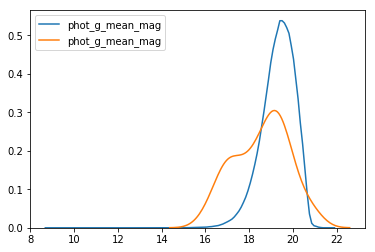

In [18]:
sns.kdeplot(d.phot_g_mean_mag)
sns.kdeplot(d2.phot_g_mean_mag)

(0, 10)

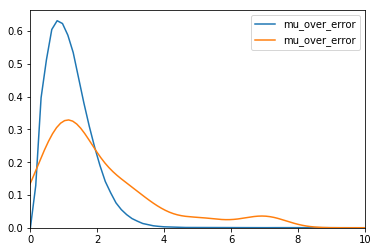

In [19]:
sns.kdeplot(d[d.mu_over_error<20].mu_over_error)
sns.kdeplot(d2.mu_over_error)
plt.xlim(0,10)

No handles with labels found to put in legend.


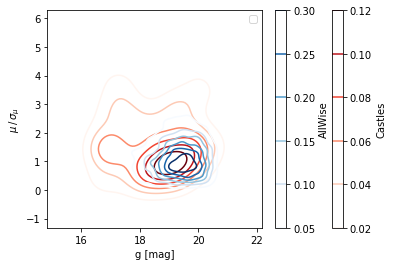

In [20]:
s = d2[d2.mu_over_error<5]
sns.kdeplot(s.phot_g_mean_mag,s.mu_over_error,cmap="Reds",n_levels=6,cbar_kws={'label': 'Castles'},cbar=True)

s = d[d.mu_over_error<5].sample(frac=0.01)
sns.kdeplot(s.phot_g_mean_mag,s.mu_over_error,cmap="Blues",n_levels=6,cbar_kws={'label': 'AllWise'},cbar=True)

plt.xlabel("g [mag]")
plt.ylabel("$\mu \, / \, \sigma_\mu$")
plt.legend()

# Analysis of AllWise query

In [21]:
d['freq'] = d.groupby(d.qso_id).source_id.transform('count')
setMu(d)

In [22]:
d['mu_norm_max'] = d.groupby(d.qso_id).mu_over_error.transform('max')

In [23]:
g = d.groupby(d.freq)['source_id','qso_id'].count()

In [24]:
g['n_candidate']=g.qso_id/g.index

In [25]:
d.groupby(d.freq).mu_over_error.max()

freq
1.0     17.650899
2.0    415.761879
3.0    111.620472
4.0     24.466072
5.0     14.908946
7.0      3.754852
Name: mu_over_error, dtype: float64

In [26]:
d.dropna()

,Unnamed: 0,qso_id,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,...,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,mu,mu_error,mu_over_error,freq,mu_norm_max


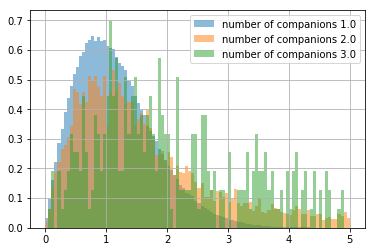

In [27]:
s=d[d.freq<4][['mu','mu_over_error','freq']]
for k0,g0 in s.groupby('freq'):
    g0.mu_over_error.hist(bins=100,range=(0,5),normed=True,label="number of companions %s"%str(k0),alpha=0.5)
plt.legend()

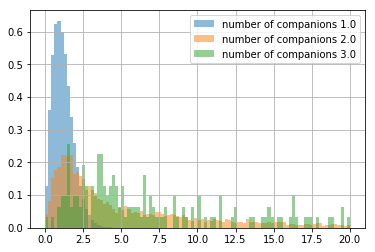

In [28]:
s=d[d.freq<4][['mu','mu_over_error','mu_norm_max','freq']]
for k0,g0 in s.groupby('freq'):
    g0.mu_norm_max.hist(bins=100,range=(0,20),normed=True,label="number of companions %s"%str(k0),alpha=0.5)
plt.legend()

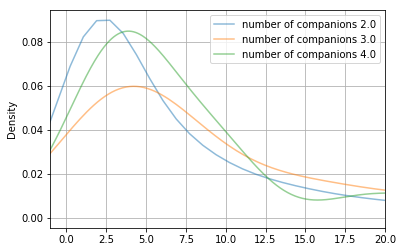

In [29]:
s=d[(d.freq<5) & (d.freq>1)][['mu','mu_over_error','mu_norm_max','freq']]
for k0,g0 in s.groupby('freq'):
    g0.mu_norm_max.plot.kde(label="number of companions %s"%str(k0),alpha=0.5)
plt.legend()
plt.xlim(-1,20)
plt.grid()

In [30]:
(s.mu_over_error-s.mu_norm_max).max()

0.0

Text(0.5,1,'Allwise QSO with 1 companion')

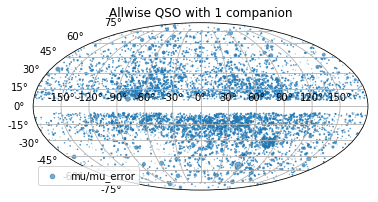

In [31]:
s = d[(d.freq==2)]
scale = u.deg.to(u.rad)
plt.subplot(111,projection="mollweide")
plt.scatter(wrap180(s.l),s.b*scale,s=0.1*s.mu_over_error,label='mu/mu_error',alpha=0.6)
plt.grid()
plt.legend()
plt.title("Allwise QSO with 1 companion")

Text(0.5,1,'Allwise QSO with 1 companion')

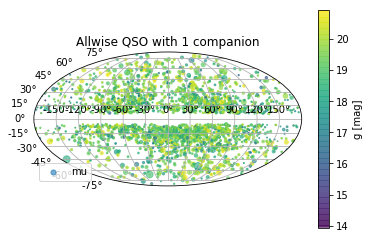

In [32]:
s = d[(d.freq==2) & (d.mu_norm_max>5)]
scale = u.deg.to(u.rad)
plt.subplot(111,projection="mollweide")
plt.scatter(wrap180(s.l),s.b*scale,c=s.phot_g_mean_mag,s=0.5*s.mu,label='mu',alpha=0.6)
plt.colorbar(label="g [mag]")
plt.grid()
plt.legend()
plt.title("Allwise QSO with 1 companion")

Text(0.5,1,'Allwise QSO with 1 companion')

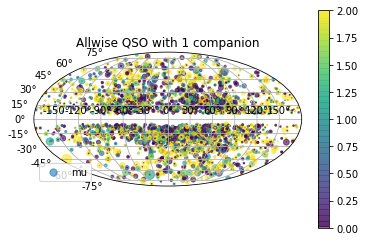

In [33]:
s = d[(d.freq==2) & (d.mu_norm_max>5)]
scale = u.deg.to(u.rad)
plt.subplot(111,projection="mollweide")
plt.scatter(wrap180(s.l),s.b*scale,c=s.parallax/s.parallax_error,s=s.mu,label='mu',alpha=0.6,vmin=0,vmax=2)
plt.colorbar()
plt.grid()
plt.legend()
plt.title("Allwise QSO with 1 companion")

Text(0.5,1,'Allwise QSO with 1 companion')

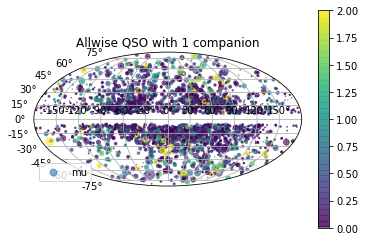

In [34]:
s = d[(d.freq==2) & (d.mu_norm_max>5) & (d.parallax_over_error<3)]
scale = u.deg.to(u.rad)
plt.subplot(111,projection="mollweide")
plt.scatter(wrap180(s.l),s.b*scale,c=s.parallax,s=s.mu,label='mu',alpha=0.6,vmin=0,vmax=2)
plt.colorbar()
plt.grid()
plt.legend()
plt.title("Allwise QSO with 1 companion")

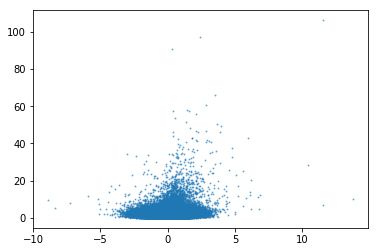

In [35]:
plt.scatter(d.parallax,d.mu,s=1,alpha=0.5)

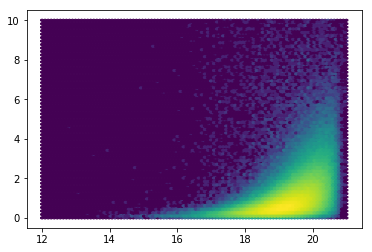

In [36]:
plt.hexbin(d.phot_g_mean_mag,d.mu,extent=(12,21,0,10),bins='log')

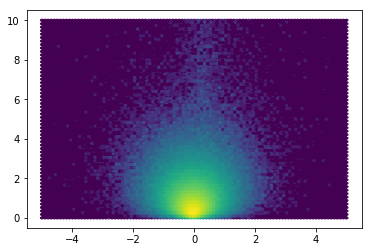

In [37]:
plt.hexbin(d.parallax,d.mu,extent=(-5,5,0,10),bins='log')

Text(0.5,1,'Allwise QSO with 1 companion')

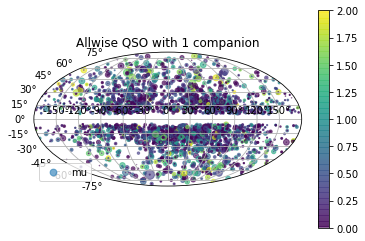

In [38]:
s = d[(d.freq==2) & (d.mu_norm_max>5) & (d.parallax<2)]
scale = u.deg.to(u.rad)
plt.subplot(111,projection="mollweide")
plt.scatter(wrap180(s.l),s.b*scale,c=s.parallax,s=s.mu,label='mu',alpha=0.6,vmin=0,vmax=2)
plt.colorbar()
plt.grid()
plt.legend()
plt.title("Allwise QSO with 1 companion")

Text(0.5,1,'Allwise QSO with 2 companions')

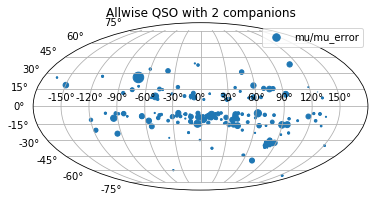

In [39]:
s = d[d.freq==3]
scale = u.deg.to(u.rad)
plt.subplot(111,projection="mollweide")
plt.scatter(wrap180(s.l),s.b*scale,s=s.mu_over_error,label='mu/mu_error')
plt.grid()
plt.legend()
plt.title('Allwise QSO with 2 companions')

Text(0.5,1,'Allwise QSO more than 2 companions')

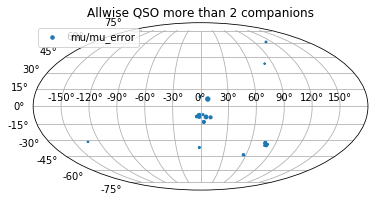

In [40]:
s = d[d.freq>3]
scale = u.deg.to(u.rad)
plt.subplot(111,projection="mollweide")
plt.scatter(wrap180(s.l),s.b*scale,s=s.mu_over_error,label='mu/mu_error')
plt.grid()
plt.legend()
plt.title('Allwise QSO more than 2 companions')

In [52]:
d[d.freq>3]

,Unnamed: 0,qso_id,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,...,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url,mu,mu_error,mu_over_error,freq,mu_norm_max
17705,17705,6.681327e+18,1.635721e+18,b'Gaia DR2 6681326549578891392',6.681327e+18,1.682964e+09,2015.5,309.511573,2.135881,-40.136830,...,NaN,NaN,NaN,b'http://geadata.esac.esa.int/data-server/data...,NaN,NaN,NaN,NaN,4.0,3.416188
17706,17706,6.681327e+18,1.635721e+18,b'Gaia DR2 6681326549578891648',6.681327e+18,1.138663e+09,2015.5,309.510784,0.575795,-40.136936,...,NaN,NaN,NaN,b'http://geadata.esac.esa.int/data-server/data...,NaN,2.070015,1.091360,1.896731,4.0,3.416188
17707,17707,6.681327e+18,1.635721e+18,b'Gaia DR2 6681326549578891520',6.681327e+18,5.853592e+08,2015.5,309.511623,0.516447,-40.137410,...,NaN,NaN,NaN,b'http://geadata.esac.esa.int/data-server/data...,NaN,2.646935,1.022906,2.587662,4.0,3.416188
17708,17708,6.681327e+18,1.635721e+18,b'Gaia DR2 6681326549580116864',6.681327e+18,2.724209e+08,2015.5,309.511072,0.578459,-40.137402,...,NaN,NaN,NaN,b'http://geadata.esac.esa.int/data-server/data...,NaN,4.152009,1.215392,3.416188,4.0,3.416188
65797,65797,6.028370e+18,1.635721e+18,b'Gaia DR2 6028370402525828992',6.028370e+18,1.920193e+08,2015.5,255.184084,2.069612,-31.717695,...,NaN,NaN,NaN,b'http://geadata.esac.esa.int/data-server/data...,NaN,NaN,NaN,NaN,4.0,18.769726
65798,65798,6.028370e+18,1.635721e+18,b'Gaia DR2 6028370402512220416',6.028370e+18,7.469409e+08,2015.5,255.185094,0.771159,-31.718036,...,NaN,NaN,NaN,b'http://geadata.esac.esa.int/data-server/data...,NaN,29.485067,1.570884,18.769726,4.0,18.769726
65799,65799,6.028370e+18,1.635721e+18,b'Gaia DR2 6028370398215475840',6.028370e+18,5.603803e+08,2015.5,255.183734,1.796457,-31.718206,...,NaN,NaN,NaN,b'http://geadata.esac.esa.int/data-server/data...,NaN,NaN,NaN,NaN,4.0,18.769726
65800,65800,6.028370e+18,1.635721e+18,b'Gaia DR2 6028370398245359488',6.028370e+18,1.342228e+09,2015.5,255.184357,0.213131,-31.718094,...,NaN,NaN,NaN,b'http://geadata.esac.esa.int/data-server/data...,NaN,0.862714,0.499613,1.726764,4.0,18.769726
73927,73927,4.654733e+18,1.635721e+18,b'Gaia DR2 4654732895123530240',4.654733e+18,1.225659e+09,2015.5,74.240653,0.670165,-70.420365,...,NaN,NaN,NaN,b'http://geadata.esac.esa.int/data-server/data...,NaN,NaN,NaN,NaN,7.0,3.754852
73928,73928,4.654733e+18,1.635721e+18,b'Gaia DR2 4654732899404552320',4.654733e+18,1.183499e+09,2015.5,74.240283,0.380759,-70.420704,...,NaN,NaN,NaN,b'http://geadata.esac.esa.int/data-server/data...,NaN,3.034065,1.120607,2.707520,7.0,3.754852


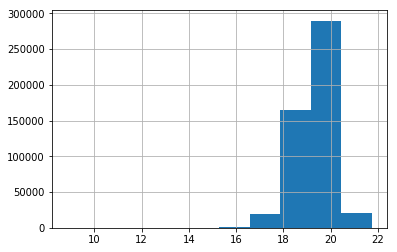

In [54]:
d.phot_g_mean_mag.hist()

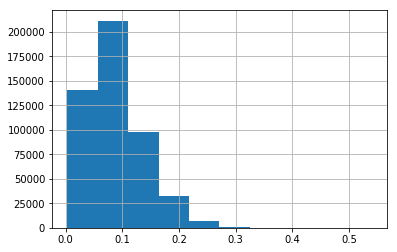

In [56]:
d.astrometric_pseudo_colour_error.hist()